In [53]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%load_ext watermark
%watermark -a 'Marcos Santana' -d -p numpy,pandas,rdkit,fastai,torch -v

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Author: Marcos Santana

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.22.0

numpy : 1.20.1
pandas: 1.2.4
rdkit : 2021.03.5
fastai: 2.5.2
torch : 1.9.0



In [54]:
import pandas as pd
import numpy as np

from utils.Fingerprinter import Fingerprinter

from fastai.tabular.all import *

from sklearn.model_selection import train_test_split

# Load data

In [55]:
data = pd.read_csv('../data/FXA_CHEMBL.csv')
data.head()

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL351435,NaN,0,461.95,0,3.73,16,O=C1CN(S(=O)(=O)c2cc3ccc(Cl)cc3s2)CCN1Cc1cc2cnccc2o1,Ki,'=',...,Coagulation factor X,Homo sapiens,SINGLE PROTEIN,CHEMBL1144944,1,Scientific Literature,J. Med. Chem.,2003,None,NaN
1,CHEMBL295802,NaN,0,493.01,0,2.14,18,O=C(CN1CCN(S(=O)(=O)c2cc3ccc(Cl)cc3s2)CC1=O)NCCc1ccncc1,Ki,'=',...,Coagulation factor X,Homo sapiens,SINGLE PROTEIN,CHEMBL1133063,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2000,None,NaN
2,CHEMBL62509,NaN,0,382.44,0,4.32,15m,C[C@H]1CC[C@@H](Oc2cccc(-c3nc4cc(C(=N)N)c(F)cc4[nH]3)c2O)CC1,Ki,'=',...,Coagulation factor X,Homo sapiens,SINGLE PROTEIN,CHEMBL1135195,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2002,None,NaN
3,CHEMBL416912,NaN,0,499.55,0,1.27,NC4,COc1cccc(S(=O)(=O)Nc2cccn(CC(=O)NCc3ccc(C(=N)N)cc3OC)c2=O)c1,Ki,'=',...,Coagulation factor X,Homo sapiens,SINGLE PROTEIN,CHEMBL1136066,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2002,None,NaN
4,CHEMBL140349,NaN,0,514.57,1,2.86,24b,Cc1cc(C(=O)Nc2ccc(-c3ccccc3S(N)(=O)=O)cc2)n(-c2ccc3nc(N)nc(N)c3c2)n1,Ki,'=',...,Coagulation factor X,Homo sapiens,SINGLE PROTEIN,CHEMBL1145122,1,Scientific Literature,J. Med. Chem.,2003,None,NaN


In [56]:
data['class_label'] = data['pChEMBL Value'].apply(lambda x : 1 if (x>=6.5) else 0)

# Featurize

In [57]:
feat_generator = Fingerprinter(smiles=data['Smiles'])
X = feat_generator.generate_fingerprint('atom_pairs',nbits=1024,radius=2)
y = data.class_label

In [58]:
feature_name = [f'fp{i}' for i in range(1024)]

In [59]:
data = pd.concat([data, pd.DataFrame(X, columns=feature_name)],axis=1)

In [60]:
data.head(2)

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,fp1014,fp1015,fp1016,fp1017,fp1018,fp1019,fp1020,fp1021,fp1022,fp1023
0,CHEMBL351435,NaN,0,461.95,0,3.73,16,O=C1CN(S(=O)(=O)c2cc3ccc(Cl)cc3s2)CCN1Cc1cc2cnccc2o1,Ki,'=',...,0,0,0,0,0,2,0,0,0,0
1,CHEMBL295802,NaN,0,493.01,0,2.14,18,O=C(CN1CCN(S(=O)(=O)c2cc3ccc(Cl)cc3s2)CC1=O)NCCc1ccncc1,Ki,'=',...,0,0,0,0,0,1,0,0,0,0


# Split data

In [61]:
trainset, testset = train_test_split(data, stratify=data['class_label'], test_size=0.20)

# Create DataLoader

**PandasDataset**

In [62]:
splits = RandomSplitter(0.2)(trainset) # Split into train and valid sets
splits

((#2616) [3012,1791,429,1892,1511,2496,3019,1255,877,1320...],
 (#654) [1278,2543,3256,2566,2218,424,2183,534,1497,922...])

In [63]:
dset = TabularPandas(df=trainset,cont_names=feature_name, 
                     y_names='class_label',y_block=CategoryBlock(),
                    splits=splits)

In [64]:
dls = dset.dataloaders(bs=32)

In [65]:
dls.show_batch()

# Multilayer perceptron

In [106]:
class MLP(nn.Module):
    '''Basic multi layer perceptron for bioactivity prediction
    
    Attributes:
    
    n_input : int
        Input matrix size
        
    n_hid : int
        Number of hidden units
        
    n_out : int
        Number of output units
    
    
    '''
    
    def __init__(self, n_input, n_hid, n_out, dropout):
        super().__init__()
        
        self.input = nn.Linear(n_input, n_hid)
        
        self.lin = nn.Sequential(nn.Linear(n_hid, n_hid),
                                 nn.ReLU(),
                                 nn.Dropout(dropout), 
                                 nn.Linear(n_hid, n_hid),
                                  nn.ReLU(),
                                 nn.Dropout(dropout))

        self.output = nn.Linear(n_hid, n_out)
                
    def forward(self, cat_features,cont_features):
    
        res = self.lin(self.input(cont_features))
        out = self.output(res)
        return out
        

In [107]:
model = MLP(n_input = X.shape[1], n_hid=100, n_out=2, dropout=0.25)

In [108]:
model.lin

Sequential(
  (0): Linear(in_features=100, out_features=100, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.25, inplace=False)
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.25, inplace=False)
)

In [109]:
metrics = [Recall(pos_label=0),Recall(pos_label=1),Precision(),MatthewsCorrCoef()]

In [110]:
learn = Learner(dls, model=model,metrics=metrics)

## Train model

**Learning rate finder**

SuggestedLRs(valley=0.0012022644514217973)

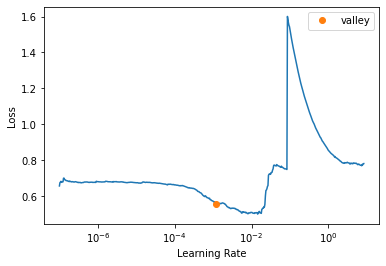

In [111]:
learn.lr_find(num_it=600)

**Training using optimal learning rate**

In [112]:
learn.fit(n_epoch=10,lr=2e-4)

epoch,train_loss,valid_loss,recall_score,recall_score,precision_score,matthews_corrcoef,time
0,0.584163,0.550179,0.411348,0.959677,0.682600,0.459106,00:01
1,0.495852,0.488003,0.578014,0.924731,0.742981,0.547567,00:01
2,0.428942,0.398717,0.780142,0.860215,0.837696,0.643431,00:01
3,0.387157,0.416479,0.670213,0.932796,0.788636,0.636482,00:01
4,0.354682,0.360795,0.783688,0.879032,0.842784,0.668143,00:01
5,0.335922,0.357615,0.833333,0.892473,0.875989,0.728167,00:01
6,0.317647,0.345267,0.804965,0.913978,0.860759,0.728018,00:01
7,0.298532,0.364058,0.751773,0.932796,0.832134,0.705295,00:01
8,0.295365,0.337836,0.815603,0.903226,0.865979,0.724711,00:01
9,0.273641,0.342438,0.797872,0.930108,0.858561,0.741355,00:01


# Evaluation

## Confusion matrix

In [113]:
clas_evaluation = ClassificationInterpretation.from_learner(learn)

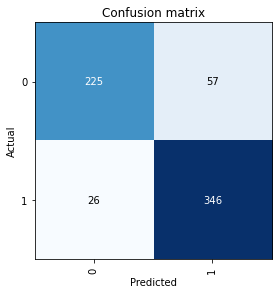

In [114]:
clas_evaluation.plot_confusion_matrix()

## Predictions on test set

In [115]:
test_dl = learn.dls.test_dl(testset)

In [116]:
test_probas, _ = learn.get_preds(dl=test_dl)

In [117]:
test_probas[0:5]

tensor([[0.9890, 0.0110],
        [0.2070, 0.7930],
        [0.4075, 0.5925],
        [0.3666, 0.6334],
        [0.4274, 0.5726]])

In [118]:
preds = test_probas.argmax(1)

In [119]:
from sklearn.metrics import matthews_corrcoef, recall_score, precision_score

In [120]:
mcc = matthews_corrcoef(testset['class_label'].values, preds)
recall = recall_score(testset['class_label'].values, preds,pos_label=1)
specificity = recall_score(testset['class_label'].values, preds,pos_label=0)
pre = precision_score(testset['class_label'].values, preds)

In [121]:
print(f'Test set\n-----\nMCC = {mcc:.3f}\nSe = {recall:.3f}\nSp = {specificity:.3f}\nPre = {pre:.3f}')

Test set
-----
MCC = 0.710
Se = 0.886
Sp = 0.824
Pre = 0.888


# Fin